In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from pandas.io.json import json_normalize
import json
import os
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [2]:
def load_df(csv_path='/home/baitong/pywork/RevenuePrediction/all/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
#     print(df.head())
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
path = '/home/baitong/pywork/RevenuePrediction/'

In [4]:
%%time
train = load_df()
test = load_df("/home/baitong/pywork/RevenuePrediction/all/test.csv")
train.shape, test.shape

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 3min 53s, sys: 4.29 s, total: 3min 57s
Wall time: 3min 57s


In [5]:
#获取不变的常量列，模型无法在常量数据计学到东西，数据与处理时需要drop
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
print(const_cols)

['socialEngagementType', 'device_browserSize', 'device_browserVersion', 'device_flashVersion', 'device_language', 'device_mobileDeviceBranding', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_operatingSystemVersion', 'device_screenColors', 'device_screenResolution', 'geoNetwork_cityId', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits', 'trafficSource_adwordsClickInfo.criteriaParameters']


In [6]:
train = train.drop(const_cols , axis=1)
test = test.drop(const_cols, axis=1)


In [7]:
####删除test中不存在的列
train = train.drop(["trafficSource_campaignCode"], axis=1)
train.shape, test.shape

((903653, 35), (804684, 34))

In [8]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [9]:
train['totals_transactionRevenue'] = train['totals_transactionRevenue'].fillna(0).astype("float")
# del train['totals_transactionRevenue']

# if 'totals_transactionRevenue' in test.columns:
#     del test['totals_transactionRevenue']

In [10]:
train.shape, test.shape

((903653, 35), (804684, 34))

In [11]:
train.drop(['trafficSource_adwordsClickInfo.adNetworkType','trafficSource_adwordsClickInfo.gclId',
          'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_adwordsClickInfo.page',
           'trafficSource_adwordsClickInfo.slot'],axis =1,inplace = True)
test.drop(['trafficSource_adwordsClickInfo.adNetworkType','trafficSource_adwordsClickInfo.gclId',
          'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_adwordsClickInfo.page',
        'trafficSource_adwordsClickInfo.slot'],axis =1,inplace = True)

In [12]:
train.shape, test.shape

((903653, 30), (804684, 29))

In [13]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,...,totals_newVisits,totals_pageviews,totals_transactionRevenue,trafficSource_adContent,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,1,1,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,1,1,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,1,1,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,1,1,0.0,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,NaN,1,0.0,NaN,(not set),True,(not provided),organic,NaN,google


In [14]:
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [15]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source'],
      dtype='object')

In [16]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [17]:
# train.info()

In [18]:
def dealMissingData(df):
    for c in df.columns:
        num_missing = df[c].isnull().sum() 
        if num_missing != 0:
            print("missing col is  ",c,'   missing num is',num_missing)
    num_feature = ["totals_bounces","totals_newVisits"]
    cat_feature = ['trafficSource_adContent','trafficSource_adContent',
                  'trafficSource_campaign','trafficSource_isTrueDirect',
                  'trafficSource_keyword','trafficSource_referralPath']
    for col in num_feature:
        df[col].fillna(0,inplace=True)
    for col in cat_feature:
        df[col].fillna(-999,inplace=True)
    for c in df.columns:
        num_missing = df[c].isnull().sum() 
        if num_missing != 0:
            print("missing col is  ",c,'   missing num is',num_missing)
    return df

In [19]:
train = dealMissingData(train)
test = dealMissingData(test)

missing col is   totals_bounces    missing num is 453023
missing col is   totals_newVisits    missing num is 200593
missing col is   totals_pageviews    missing num is 100
missing col is   trafficSource_adContent    missing num is 892707
missing col is   trafficSource_isTrueDirect    missing num is 629648
missing col is   trafficSource_keyword    missing num is 502929
missing col is   trafficSource_referralPath    missing num is 572712
missing col is   totals_pageviews    missing num is 100
missing col is   totals_bounces    missing num is 383736
missing col is   totals_newVisits    missing num is 200314
missing col is   totals_pageviews    missing num is 139
missing col is   trafficSource_adContent    missing num is 750893
missing col is   trafficSource_isTrueDirect    missing num is 544171
missing col is   trafficSource_keyword    missing num is 391032
missing col is   trafficSource_referralPath    missing num is 569361
missing col is   totals_pageviews    missing num is 139


In [20]:
clearRare("device_browser")
clearRare("device_operatingSystem")
clearRare("geoNetwork_country")
clearRare("geoNetwork_city")
clearRare("geoNetwork_metro")
clearRare("geoNetwork_networkDomain")
clearRare("geoNetwork_region")
clearRare("geoNetwork_subContinent")
clearRare("trafficSource_adContent")
clearRare("trafficSource_campaign")
clearRare("trafficSource_keyword")
clearRare("trafficSource_medium")
clearRare("trafficSource_referralPath")
clearRare("trafficSource_source")

Set 98 device_browser categories to 'other'; now there are 11 categories in train
Set 15 device_operatingSystem categories to 'other'; now there are 8 categories in train
Set 160 geoNetwork_country categories to 'other'; now there are 60 categories in train
Set 656 geoNetwork_city categories to 'other'; now there are 77 categories in train
Set 86 geoNetwork_metro categories to 'other'; now there are 24 categories in train
Set 25689 geoNetwork_networkDomain categories to 'other'; now there are 62 categories in train
Set 314 geoNetwork_region categories to 'other'; now there are 62 categories in train
Set 5 geoNetwork_subContinent categories to 'other'; now there are 19 categories in train
Set 46 trafficSource_adContent categories to 'other'; now there are 4 categories in train
Set 23 trafficSource_campaign categories to 'other'; now there are 5 categories in train
Set 2409 trafficSource_keyword categories to 'other'; now there are 8 categories in train
Set 1 trafficSource_medium categor

In [21]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

In [22]:
###填补totals.pageviews值
predmis = train[train['totals_pageviews'].isnull()]['totals_hits'].values
train.loc[(train['totals_pageviews'].isnull()),'totals_pageviews' ] = predmis

predmis = test[test['totals_pageviews'].isnull()]['totals_hits'].values
test.loc[(test['totals_pageviews'].isnull()),'totals_pageviews' ] = predmis


In [23]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!

In [24]:
# train['weekday'].value_counts()

In [25]:
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

/home/baitong/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [26]:
for df in [train, test]:
    df['source_country'] = df['trafficSource_source'] + '_' + df['geoNetwork_country']
    df['campaign_medium'] = df['trafficSource_campaign'] + '_' + df['trafficSource_medium']
    df['browser_category'] = df['device_browser'] + '_' + df['device_deviceCategory']
    df['browser_os'] = df['device_browser'] + '_' + df['device_operatingSystem']

In [27]:
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device_deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device_browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device_operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country','geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region','geoNetwork_subContinent']:
        for j in ['device_browser','device_deviceCategory', 'device_operatingSystem', 'trafficSource_source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content_source'] = df['trafficSource_adContent'].astype(str) + "_" + df['source_country']
    df['medium_source'] = df['trafficSource_medium'] + "_" + df['source_country']

In [28]:
train['totals_hits'] = train['totals_hits'].astype("float")
test['totals_hits'] = test['totals_hits'].astype("float")
train['totals_pageviews'] = train['totals_pageviews'].astype("float")
test['totals_pageviews'] = test['totals_pageviews'].astype("float")


In [29]:
for feature in ["totals_hits", "totals_pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

In [30]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals_transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]
print("cat_cols: ",cat_cols)
print("real_cols: ",real_cols)

cat_cols:  ['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces', 'totals_newVisits', 'trafficSource_adContent', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'weekday', 'source_country', 'campaign_medium', 'browser_category', 'browser_os', 'device_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork_city_device_browser', 'geoNetwork_city_device_deviceCategory', 'geoNetwork_city_device_operatingSystem', 'geoNetwork_city_trafficSource_source', 'geoNetwork_continent_device_browser', 'geoNetwork_continent_device_deviceCategory', 'geoNetwork_continent_device_operatingSystem', 'geoNetwork_continent_trafficSource_source', 'geoNetwo

In [31]:
train[cat_cols].nunique()

channelGrouping                                       8
device_browser                                       11
device_deviceCategory                                 3
device_operatingSystem                                8
geoNetwork_city                                      77
geoNetwork_continent                                  6
geoNetwork_country                                   60
geoNetwork_metro                                     24
geoNetwork_networkDomain                             62
geoNetwork_region                                    62
geoNetwork_subContinent                              19
totals_bounces                                        2
totals_newVisits                                      2
trafficSource_adContent                               4
trafficSource_campaign                                5
trafficSource_isTrueDirect                            2
trafficSource_keyword                                 8
trafficSource_medium                            

In [32]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [33]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [34]:
y_reg = train['totals_transactionRevenue']

In [35]:
folds = get_folds(df=train, n_splits=5)

train_features = real_cols + cat_cols
importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x,np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.63937	valid_0's l2: 2.68753
[200]	valid_0's rmse: 1.6222	valid_0's l2: 2.63152
[300]	valid_0's rmse: 1.61783	valid_0's l2: 2.61737
[400]	valid_0's rmse: 1.61461	valid_0's l2: 2.60698
[500]	valid_0's rmse: 1.61326	valid_0's l2: 2.60261
[600]	valid_0's rmse: 1.61254	valid_0's l2: 2.6003
[700]	valid_0's rmse: 1.61154	valid_0's l2: 2.59707
Early stopping, best iteration is:
[713]	valid_0's rmse: 1.61135	valid_0's l2: 2.59644
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61583	valid_0's l2: 2.61091
[200]	valid_0's rmse: 1.60191	valid_0's l2: 2.5661
[300]	valid_0's rmse: 1.59749	valid_0's l2: 2.55197
[400]	valid_0's rmse: 1.59446	valid_0's l2: 2.5423
[500]	valid_0's rmse: 1.59302	valid_0's l2: 2.5377
Early stopping, best iteration is:
[488]	valid_0's rmse: 1.59279	valid_0's l2: 2.53697
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse:

1.599515600971078

In [36]:
len(oof_reg_preds),len(train)

(903653, 903653)

In [37]:
len(sub_reg_preds),len(test)

(804684, 804684)

In [38]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

In [39]:
##计算单个用户会话总数
train["sess_count"]=1;
train_sess_num = train[['fullVisitorId', 'sess_count']].groupby('fullVisitorId').sum()
test["sess_count"]=1;
test_sess_num = test[['fullVisitorId', 'sess_count']].groupby('fullVisitorId').sum()

In [41]:
###将大于20次的会话数量限制为20 （大于20次数据过少）
train_sess_num['sess_count']=train_sess_num['sess_count'].apply(lambda x: 20 if x>20 else x)
test_sess_num['sess_count']=test_sess_num['sess_count'].apply(lambda x: 20 if x>20 else x)

In [45]:
# train_sess_num['sess_count'].value_counts()

In [46]:
####这里采用均值合并，对于类型特征来说并不合理
train_agg = train[train_features+['fullVisitorId']].groupby('fullVisitorId').mean()

In [52]:
train_pred = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()
len(train_pred)

714167

In [56]:
train_fulldata = pd.concat([train_agg, train_pred,train_sess_num], axis=1).astype(float)

In [57]:
test_agg = test[train_features+['fullVisitorId']].groupby('fullVisitorId').mean()
test_pred = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()
test_fulldata = pd.concat([test_agg, test_pred,test_sess_num], axis=1).astype(float)

In [61]:
test_fulldata.shape,train_fulldata.shape

((617242, 70), (714167, 70))

In [62]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [64]:
test_fulldata.head(0)

,device_isMobile,time,totals_hits,totals_pageviews,visitNumber,prev_session,next_session,usermean_totals_hits,usermean_totals_pageviews,usermax_visitNumber,...,geoNetwork_region_device_operatingSystem,geoNetwork_region_trafficSource_source,geoNetwork_subContinent_device_browser,geoNetwork_subContinent_device_deviceCategory,geoNetwork_subContinent_device_operatingSystem,geoNetwork_subContinent_trafficSource_source,content_source,medium_source,predictions,sess_count
fullVisitorId,,,,,,,,,,,,,,,,,,,,,


In [66]:
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

lgb_oof_preds = np.zeros(train_fulldata.shape[0])
lgb_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    lgb_oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    lgb_oof_preds[lgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(test_fulldata[train_fulldata.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    lgb_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), lgb_oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.54045	TRAIN's l2: 2.37298	VALID's rmse: 1.59413	VALID's l2: 2.54125
Early stopping, best iteration is:
[144]	TRAIN's rmse: 1.52004	TRAIN's l2: 2.31052	VALID's rmse: 1.59131	VALID's l2: 2.53227
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.53835	TRAIN's l2: 2.36652	VALID's rmse: 1.59416	VALID's l2: 2.54134
[200]	TRAIN's rmse: 1.50352	TRAIN's l2: 2.26057	VALID's rmse: 1.58952	VALID's l2: 2.52658
Early stopping, best iteration is:
[182]	TRAIN's rmse: 1.50771	TRAIN's l2: 2.27318	VALID's rmse: 1.58931	VALID's l2: 2.52592
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.54196	TRAIN's l2: 2.37765	VALID's rmse: 1.58676	VALID's l2: 2.51781
Early stopping, best iteration is:
[145]	TRAIN's rmse: 1.52135	TRAIN's l2: 2.31451	VALID's rmse: 1.58312	VALID's l2: 2.50625
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rms

1.584135558437783

/home/baitong/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


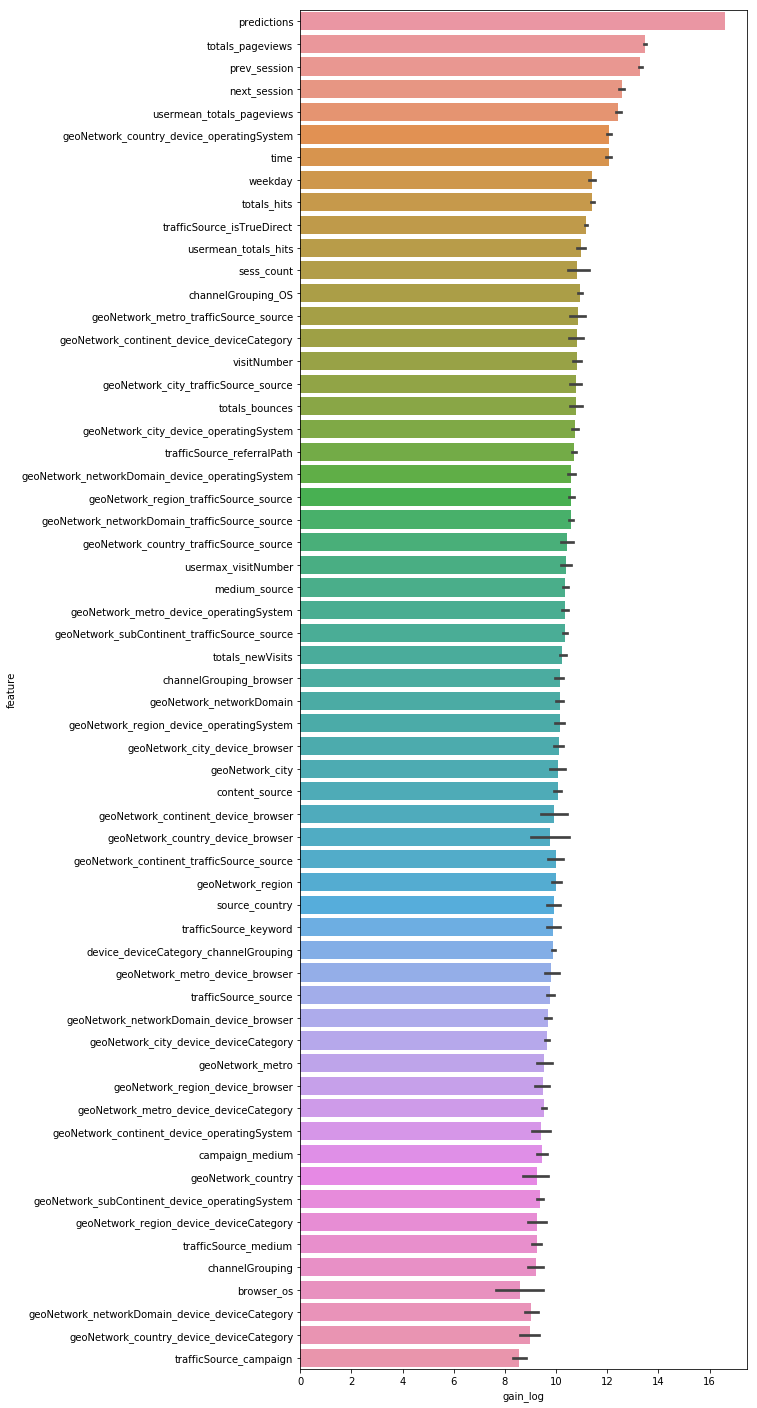

In [67]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [68]:
test_fulldata['PredictedLogRevenue'] = lgb_sub_preds
test_fulldata[['PredictedLogRevenue']].to_csv('/home/baitong/pywork/RevenuePrediction/submission.csv', index=True)

In [72]:
xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

In [74]:
from xgboost import XGBRegressor
fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}

folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

xgb_oof_preds = np.zeros(train_fulldata.shape[0])
xgb_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    xgb = XGBRegressor(**xgb_params, n_estimators=1000)
    
    xgb.fit(trn_x, np.log1p(trn_y),
            eval_set=[(val_x, np.log1p(val_y))],
            early_stopping_rounds=50,
            eval_metric='rmse',
            verbose=100)
    
    xgb_oof_preds[val_] = xgb.predict(val_x)
    xgb_oof_preds[xgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = xgb.predict(test_fulldata[train_fulldata.columns])
    _preds[_preds < 0] = 0
    xgb_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), xgb_oof_preds) ** .5

[0]	validation_0-rmse:2.10861
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.84239
[200]	validation_0-rmse:1.75119
[300]	validation_0-rmse:1.70989
[400]	validation_0-rmse:1.67447
[500]	validation_0-rmse:1.65027
[600]	validation_0-rmse:1.63739
[700]	validation_0-rmse:1.63128
[800]	validation_0-rmse:1.62494
[900]	validation_0-rmse:1.61894
[999]	validation_0-rmse:1.61455
[0]	validation_0-rmse:2.10944
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.84595
[200]	validation_0-rmse:1.76043
[300]	validation_0-rmse:1.70521
[400]	validation_0-rmse:1.67943
[500]	validation_0-rmse:1.66075
[600]	validation_0-rmse:1.64648
[700]	validation_0-rmse:1.63086
[800]	validation_0-rmse:1.62313
[900]	validation_0-rmse:1.61786
[999]	validation_0-rmse:1.61572
[0]	validation_0-rmse:2.1153
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.88544
[200]	validation_0-rmse:1.7674
[300]	validat

1.612010226032669

In [75]:
cat_param = {
    'learning_rate' :0.03,
    'depth' :10,
    'eval_metric' :'RMSE',
    'od_type' :'Iter',
    'metric_period ' : 50,
    'od_wait' : 20,
    'seed' : 42
    
}

In [76]:
from catboost import CatBoostRegressor
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

cat_oof_preds = np.zeros(train_fulldata.shape[0])
cat_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    cat = CatBoostRegressor(iterations=1000,learning_rate=0.03,
                            depth=10,
                            eval_metric='RMSE',
                            random_seed = 42,
                            bagging_temperature = 0.2,
                            od_type='Iter',
                            metric_period = 50,
                            od_wait=20)
    cat.fit(trn_x, np.log1p(trn_y), 
            eval_set=[(val_x, np.log1p(val_y))],
            early_stopping_rounds=50,
            use_best_model=True,
            verbose=100)
    cat_oof_preds[val_] = cat.predict(val_x)
    cat_oof_preds[cat_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = cat.predict(test_fulldata[train_fulldata.columns])
    _preds[_preds < 0] = 0
    cat_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), cat_oof_preds) ** .5

0:	learn: 2.0873755	test: 2.0880079	best: 2.0880079 (0)	total: 241ms	remaining: 4m
100:	learn: 1.5434232	test: 1.5980193	best: 1.5980193 (100)	total: 19.2s	remaining: 2m 50s
200:	learn: 1.5012382	test: 1.5927742	best: 1.5927742 (200)	total: 38s	remaining: 2m 30s
300:	learn: 1.4662710	test: 1.5927256	best: 1.5926296 (293)	total: 57.1s	remaining: 2m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.592629626
bestIteration = 293

Shrink model to first 294 iterations.


0:	learn: 2.0870499	test: 2.0896769	best: 2.0896769 (0)	total: 188ms	remaining: 3m 8s
100:	learn: 1.5413190	test: 1.5940429	best: 1.5940429 (100)	total: 19.1s	remaining: 2m 50s
200:	learn: 1.4997257	test: 1.5904363	best: 1.5904363 (200)	total: 39s	remaining: 2m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.590436308
bestIteration = 200

Shrink model to first 201 iterations.


0:	learn: 2.0867399	test: 2.0905817	best: 2.0905817 (0)	total: 187ms	remaining: 3m 7s
100:	learn: 1.5435921	test: 1.5860859	best: 1.5860859 (100)	total: 18.9s	remaining: 2m 48s
200:	learn: 1.5000870	test: 1.5820469	best: 1.5818877 (185)	total: 37.7s	remaining: 2m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.58188766
bestIteration = 185

Shrink model to first 186 iterations.


0:	learn: 2.0904027	test: 2.0752433	best: 2.0752433 (0)	total: 187ms	remaining: 3m 6s
100:	learn: 1.5512054	test: 1.5708082	best: 1.5708082 (100)	total: 18.7s	remaining: 2m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.569266736
bestIteration = 142

Shrink model to first 143 iterations.


0:	learn: 2.0855031	test: 2.0948668	best: 2.0948668 (0)	total: 186ms	remaining: 3m 5s
100:	learn: 1.5401971	test: 1.6059076	best: 1.6059076 (100)	total: 18.7s	remaining: 2m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.604014675
bestIteration = 144

Shrink model to first 145 iterations.


1.5876815419882624

In [78]:
test_fulldata['lgb_pred'] = lgb_sub_preds
test_fulldata['xgb_pred'] = xgb_sub_preds
test_fulldata['cst_pred'] = cat_sub_preds
test_fulldata[['lgb_pred','xgb_pred','cst_pred']]

,lgb_pred,xgb_pred,cst_pred
fullVisitorId,,,
0000000259678714014,0.127204,0.761302,0.115343
0000049363351866189,0.005821,0.002107,0.022508
0000053049821714864,0.005441,0.019225,0.000170
0000059488412965267,0.005821,0.195502,0.057998
0000085840370633780,0.005441,0.021327,0.003715
0000091131414287111,0.005441,0.001457,0.000000
0000117255350596610,5.995991,5.858634,6.537575
0000118334805178127,0.005441,0.035357,0.000000
0000130646294093000,0.005441,0.002165,0.000000
